# Simple Reinforcement Algorithms

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt,log
import numpy as np
import random
from typing import List

In [8]:
#Generate a bunch of random rewards 

frame = pd.DataFrame(np.zeros((500,2)),columns=["arm","reward"])
frame['reward'] = np.random.random(500)
frame['arm'] = np.random.choice(a=[0,1],size=500)


In [9]:
frame

,arm,reward
0,0,0.241640
1,1,0.596946
2,0,0.960291
3,0,0.741436
4,1,0.187200
...,...,...
495,0,0.927497
496,1,0.864664
497,1,0.673169
498,1,0.572402


In [201]:
def greedy(a: float, b: float, datarr: List[int], n: int):
    """
    The greedy algorithm follows the problem-solving heuristic of making the 
    locally optimal choice at each stage.
    
    Parameters:
        a (float): the probability of reward by choosing arm 0
        b (float): the probability of reward by choosing arm 1
        datarr (List[int]): used for graphing algorithm behaviour, size = n, each element stores the p(exploiting arm)
        n (int): number of trials 
    """
    
    #Step#1: initialising a bunch of shit
    #the two parameters are the two probabilities of the arms resulting in positive rewards
    successes = [1, 1]
    total_reward_tracker = [0]*n
    total_reward = 0
    total_pulls = [1, 1]
    if a > b:
        best_arm = 0
    else:
        best_arm = 1
    
    #Step#2: picking one of the arms!!
    for i in range(n):
        predicted_probs = [successes[0]/total_pulls[0], successes[1]/total_pulls[1]]
        choice = np.argmax(predicted_probs)
        datarr[i] += choice

        #Step#3: based on the arm choice, we generate the reward
        if choice == 0:
            pull = np.random.choice([0, 1], p = (1 - a, a))
            if pull == 1:
                successes[0] += 1
            total_pulls[0] += 1
        else:
            pull = np.random.choice([0,1], p = (1 - b, b))
            if pull == 1:
                successes[1] += 1
            total_pulls[1] += 1

In [196]:
def allocation_grapher(n: int, datarr: List[int], algo_name: str):
    """
    Parameters:
        n (int): number of trials
        datarr (List[int]): used for graphing algorithm behaviour, size = n, each element stores the p(exploiting arm)
        algo_name (str): name of algorithm being used.
    """
    fig, ax = plt.subplots()
    # Plot the proportion of allocations of one of the arms
    ax.plot(range(1, n + 1), datarr, label="arm_1")
    # Plot the proportion of allocations of the other arm 
    ax.plot(range(1, n + 1), 1- datarr, label="arm_2")

    plt.xlabel('Time')
    plt.ylabel('Proportion (%) allocated')
    plt.title(f'{algo_name} Algorithm Arm Allocation Over Time')
    plt.ylim(0,1)
    plt.plot(range(1,n+1), 1+np.zeros(n))
    leg = ax.legend();
    

In [197]:
# n is the horizon, the amount of time-steps
n = 200

# data array we are going to use for plotting. Each element is mapping timestep t onto P(t) = probability of picking arm 1 (between arm 0 and arm 1)
# it is initially set to have all elements as 0
greedyarr = np.zeros(n)

In [198]:
# num_sims is the number of times we want to run the algorithm. We have to do this to actually calculate P(t) for each timestep t
num_sims = 500
for num_sim in range(num_sims):
    greedy(0.3, 0.32, greedyarr, n)

# Now we have an incomplete version of the data array. Currently, it holds the counts for the #times that arm 1 has been pulled at each timestep t
# What we NEED to do, is divide each element by num_sims. This gets us P(t) because it is the proportion of times arm 1 has been pulled at timestep t
greedyarr = greedyarr/num_sims

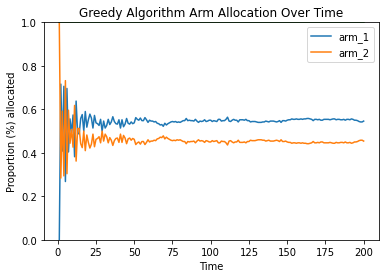

In [199]:
allocation_grapher(200, greedyarr, "Greedy")

In [33]:
def e_greedy(a: float, b: float, datarr: List[int], n: int, e: float):
    """
    Parameters:
        a (float):the probability of reward by choosing arm 0
        b (float): the probability of reward by choosing arm 1
        datarr (List[int]): used for graphing algorithm behaviour, size = n, each element stores the p(exploiting arm)
        n (int): number of trials 
        e (float): epsilon, the probability of exploration
    """
    
    #Step#1: initialising a bunch of shit
    #the two parameters are the two probabilities of the arms resulting in positive rewards
    successes = [1, 1]
    losses = [0, 0]
    total_pulls = [1, 1]
    total_reward = [0]*n
    
    #Step#2: picking one of the arms!!
    for i in range(n):
        #variable for making a choice between exploitation and exploration
        var = np.random.choice([0,1], p=(1-e,e))
        if var == 0:
            predicted_probs = [successes[0]/total_pulls[0], successes[1]/total_pulls[1]]
            choice = np.argmax(predicted_probs)
            datarr[i] += choice
        else: 
            choice = np.random.choice([0,1], p=(0.5,0.5))
            datarr[i] += choice

        #Step#3: based on the arm choice, we generate the reward
        if choice == 0:
            a_pull = np.random.choice([0, 1], p = (1 - a, a))
            if a_pull == 1:
                successes[0] += 1
            total_pulls[0] += 1
        else: 
            b_pull = np.random.choice([0,1], p = (1 - b, b))
            if b_pull == 1:
                successes[1] += 1
            total_pulls[1] += 1

In [147]:
epsilons = [0.05, 0.1, 0.2, 0.35, 0.5]

def run_multi_plot_sims(n: int, num_sims: int, prob_a: float, prob_b: float, 
                        numarr: List[int], intervals:List[float], algorithm: callable, 
                        algo_name: str, interval_name: str):
    """
    Runs num_sims simulations using the given algorithm and numarr. It iteratively feeds in hyperparameters
    from the interval list, graphing the algorithm's arm allocation over time with each one. 
    
        Parameters:
            n (int): number of trials 
            num_sims (int): number of simulations performed by the algorithm
            prob_a (float): the probability of reward by choosing arm 0
            prob_b (float): the probability of reward by choosing arm 1
            numarr (int): used for graphing algorithm behaviour, size = n, each element stores the p(exploiting arm)
            intervals (List[int]): list of different hyperparameters to be fed into the algorithm
            algorithm (callable): algorithm being run on numarr
            algo_name (str): name of algorithm being run
            interval_name (str): name of the hyperparameter fed into the algorithm
    """
    
    for num in range(0, len(intervals) - 1):
        numarr = np.zeros(n)
        for num_sim in range(num_sims):
            algorithm(prob_a, prob_b, numarr, n, intervals[num])
        numarr = numarr/num_sims
        allocation_grapher(200, numarr, f"{algo_name} ({interval_name}={intervals[num]})")
            


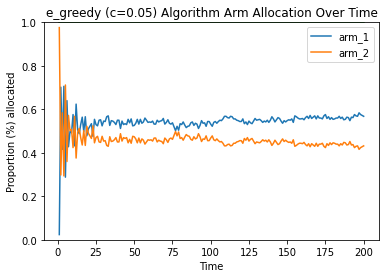

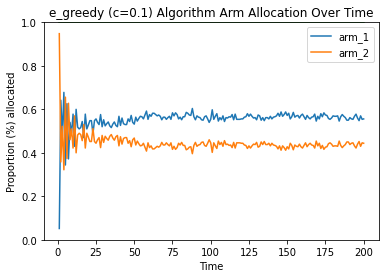

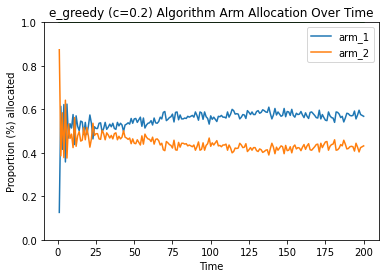

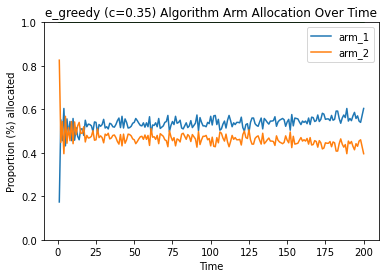

In [192]:
run_multi_plot_sims(200, 500, 0.3, 0.32, egreedyarr, epsilons, e_greedy, "e_greedy", "c")

In [193]:
def regulariser(n: int, n_j: int):
    return sqrt((2*log(n))/n_j)

def UCB(a: float, b: float, datarr: List[int], n:int):
    """
    Parameters:
        a (float):the probability of reward by choosing arm 0
        b (float): the probability of reward by choosing arm 1
        datarr (List[int]): used for graphing algorithm behaviour, size = n, each element stores the p(exploiting arm)
        n (int): number of trials 
    """
    #Step#1: initialising a bunch of shit
    #the two parameters are the two probabilities of the arms resulting in positive rewards
    successes = [1, 1]
    losses = [0, 0]
    total_pulls = [1, 1]

    #Step#2: picking one of the arms!!
    for i in range(n):
        predicted_conf_probs = [(successes[0]/total_pulls[0])+regulariser(sum(total_pulls),total_pulls[0]), 
                                (successes[1]/total_pulls[1])+regulariser(sum(total_pulls),total_pulls[1])]
        choice = np.argmax(predicted_conf_probs)
        datarr[i] += choice
        
        #Step#3: based on the arm choice, we generate the reward
        if choice == 0:
            a_pull = np.random.choice([0, 1], p = (1 - a, a))
            if a_pull == 1:
                successes[0] += 1
            total_pulls[0] += 1
        else:
            b_pull = np.random.choice([0,1], p = (1 - b, b))
            if b_pull == 1:
                successes[1] += 1
            total_pulls[1] += 1

In [194]:
n = 200
datarr_ucb = np.zeros(n)
num_sims = 500
for num_sim in range(num_sims):
    UCB(0.35, 0.3, datarr_ucb, n)
datarr_ucb = (datarr_ucb/num_sims)

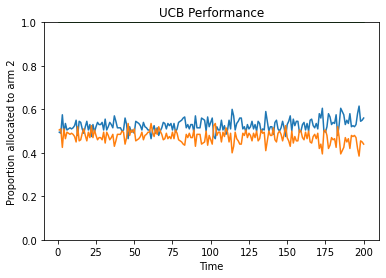

In [108]:
allocation_grapher(200, datarr_TS, "UCB")

In [79]:
def Thompson_Sampling(a: float, b: float, datarr: List[int], n:int):
    """
    Parameters:
        a (float):the probability of reward by choosing arm 0
        b (float): the probability of reward by choosing arm 1
        datarr (List[int]): used for graphing algorithm behaviour, size = n, each element stores the p(exploiting arm)
        n (int): number of trials 
    """
    #Step#1: initialising a bunch of shit
    #the two parameters are the two probabilities of the arms resulting in positive rewards
    successes = [0, 0]
    total_pulls = [0, 0]

    #Step#2: picking one of the arms!!
    for i in range(n):
        dist1 = np.random.beta(1 + successes[0], 1 + total_pulls[0] - successes[0])
        dist2 = np.random.beta(1 + successes[1], 1 + total_pulls[1] - successes[1])
        predicted_probs = [dist1, dist2]
        choice = np.argmax(predicted_probs)
        datarr[i] += choice

        #Step#3: based on the arm choice, we generate the reward
        if choice == 0:
            a_pull = np.random.choice([0, 1], p = (1 - a, a))
            if a_pull == 1:
                successes[0] += 1
            total_pulls[0] += 1


        else:
            b_pull = np.random.choice([0,1], p = (1 - b, b))
            if b_pull == 1:
                successes[1] += 1
            total_pulls[1] += 1

In [80]:
n = 200
datarr_TS = np.zeros(n)
num_sims = 200
for num_sim in range(num_sims):
    thompson(0.3, 0.32, datarr_TS, n)
datarr_TS = datarr_TS/num_sims


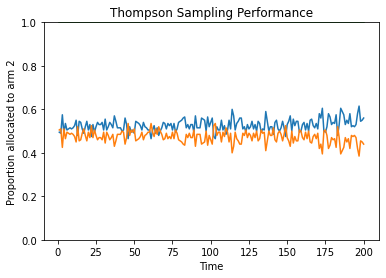

In [100]:
allocation_grapher(200, datarr_TS, "Thompson Sampling")

In [164]:
def TSPostDiff(a: float, b: float, datarr: List[int], n: int, threshold: float):
    """
    TSPostDiff combines uniform random assignment and Thompson Sampling. The algorithm 
    iterates through the randomly generated data, randomly drawing from two beta distributions that
    represent the algorithm's confidence that each arm has the highest actual reward. 
    If the difference between the random draws is lower than a specified threshold,
    the algorithm instead randomly assigns an arm.
    
    Parameters:
        a (float):the probability of reward by choosing arm 0
        b (float): the probability of reward by choosing arm 1
        datarr (List[int]): used for graphing algorithm behaviour, size = n, 
        each element stores the p(exploiting arm)
        n (int): number of trials  
    """
    #Step#1: initialising a bunch of shit
    #the two parameters are the two probabilities of the arms resulting in positive rewards
    successes = [0, 0]
    total_pulls = [0, 0]

    #Step#2: picking one of the arms!!
    for i in range(n):
        dist1 = np.random.beta(1 + successes[0], 1 + total_pulls[0] - successes[0])
        dist2 = np.random.beta(1 + successes[1], 1 + total_pulls[1] - successes[1])
        predicted_probs = [dist1, dist2]
        choice = np.argmax(predicted_probs)
        datarr[i] += choice

        #Step#3: based on the arm choice, we generate the reward
        if abs(dist1 - dist2) < threshold:
            np.random.choice([0,1], p = (0.5,0.5))
        else:
            if choice == 0:
                a_pull = np.random.choice([0, 1], p = (1 - a, a))
                if a_pull == 1:
                    successes[0] += 1
                total_pulls[0] += 1
            elif choice == 1: 
                b_pull = np.random.choice([0,1], p = (1 - b, b))
                if b_pull == 1:
                    successes[1] += 1
                total_pulls[1] += 1




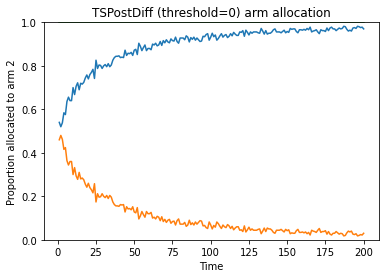

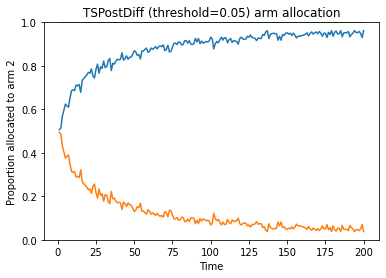

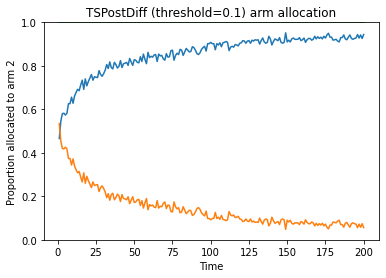

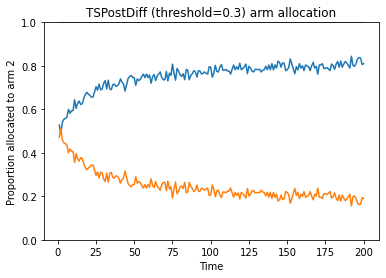

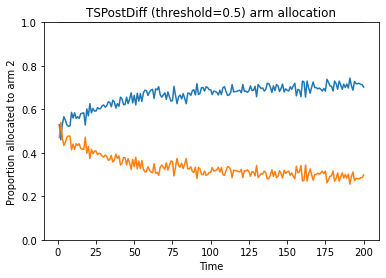

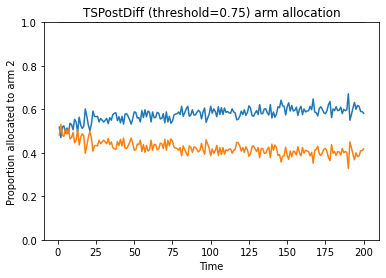

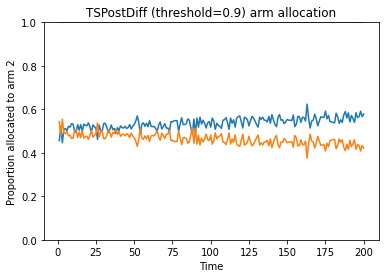

In [165]:
datarr_TSPD = np.zeros(n)
thresholds = [0, 0.05, 0.1, 0.3, 0.5, 0.75, 0.9, 1]

run_multi_plot_sims(200, 500, 0.3, 0.55, datarr_TSPD, thresholds, TSPostDiff, "TSPostDiff", 'threshold')